In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.linear_model import LinearRegression

# **Завантаження і аналіз датасету**

In [ ]:
path = kagglehub.dataset_download("undefinenull/million-song-dataset-spotify-lastfm")
path += '/Music Info.csv'

100%|██████████| 639M/639M [00:08<00:00, 76.1MB/s]

Extracting files...


In [ ]:
df = pd.read_csv(path, on_bad_lines='skip')
df.shape

(50683, 21)

Переглянемо декілька рядків датасету. Він містить 50683 рядки та 21 колонку (серед яких є дані зібрані зі Spotify та Last.fm, наприклад колонка tags містить дані з Last.fm, яких немає в системі Spotify, також певні колонки спільні, наприклад, назва або артисти)

In [ ]:
df.columns

Index(['track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id',
       'tags', 'genre', 'year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [ ]:
df.sample(5)

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
7233,TRRQVMQ12903CBDFCC,Heartbeat Song,Kelly Clarkson,https://p.scdn.co/mp3-preview/bf083c904ad9f4ff...,095u7qOW0hhENy4OswitwG,"pop, female_vocalists, dance",Rock,2016,198624,0.480,...,6,-4.434,1,0.0482,0.010200,0.000000,0.0724,0.4950,149.104,4
7454,TRNTDGO128F92EA2E9,Seasons In The Abyss,Slayer,https://p.scdn.co/mp3-preview/9d7a0b627a3fbf46...,0s8FRkTdh4LN4v2a31tSvJ,"metal, heavy_metal, thrash_metal",Metal,2003,404386,0.229,...,5,-5.996,0,0.1440,0.014100,0.000016,0.6880,0.2270,80.413,4
16532,TRKRJAS128F4240A66,Which Way,Graveworm,https://p.scdn.co/mp3-preview/b3862db51be3aaa3...,0bENUbExyYHG5gSCXoNTXe,"black_metal, melodic_death_metal, gothic_metal",NaN,2006,332080,0.409,...,3,-1.943,1,0.1120,0.000013,0.683000,0.1490,0.0693,114.983,4
44924,TROTAYO12903CCC37B,Make It Tonight,High Contrast,https://p.scdn.co/mp3-preview/b9e4581fa3b316d6...,0JSyBiC7t3cOlMD08hfUN5,drum_and_bass,Electronic,2002,453973,0.533,...,9,-7.006,0,0.0740,0.035200,0.669000,0.1380,0.5300,173.015,4
24587,TRUZLZY12903CBE278,Nostrovia,Testament,https://p.scdn.co/mp3-preview/ca02cfec4b1154d1...,0YVDEKf23Le791HkWx3RoK,thrash_metal,NaN,1997,92440,0.510,...,2,-6.241,1,0.0425,0.000006,0.890000,0.1400,0.4830,108.169,3


Колонку 'spotify_preview_url' можна видалити, оскільки вона не містить жодної важливої інформації для подальшого аналізу.

In [ ]:
df = df.drop(labels=['spotify_preview_url'], axis=1)

Переглянемо та проаналізуємо кількість відсутніх значень. Колонки 'tags' та 'genre' містять пропущені значення.

In [ ]:
null_cols = df.columns[df.isna().sum() > 0]
null_cols

Index(['tags', 'genre'], dtype='object')

In [ ]:
print('Кількість відсутніх значень та їх відсоток від загальної кількості даних')
shape = df.shape
for col in null_cols:
  nun_count = df[col].isna().sum()
  print(f'{col:<10} {nun_count:<10} {nun_count / shape[0] * 100:.3f}%')

Кількість відсутніх значень та їх відсоток від загальної кількості даних
tags       1127       2.224%
genre      28335      55.906%


In [ ]:
print('Кількість відсутніх значень для обох колонок водночас та їх відсоток від загальної кількості даних')
num_both = df[(df['genre'].isna()) & (df['tags'].isna())].shape[0]
print(f'{num_both:<10} {num_both / shape[0] * 100:.3f}%')

Кількість відсутніх значень для обох колонок водночас та їх відсоток від загальної кількості даних
695        1.371%


Значення жанру відсутнє в більше ніж 50% рядків, тому колонку слід видалити. Теги не несуть ніякої інформації при аналізі даних Spotify, тому їх також можна видалити.

In [ ]:
df = df.drop(labels=null_cols, axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50683 entries, 0 to 50682
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          50683 non-null  object 
 1   name              50683 non-null  object 
 2   artist            50683 non-null  object 
 3   spotify_id        50683 non-null  object 
 4   year              50683 non-null  int64  
 5   duration_ms       50683 non-null  int64  
 6   danceability      50683 non-null  float64
 7   energy            50683 non-null  float64
 8   key               50683 non-null  int64  
 9   loudness          50683 non-null  float64
 10  mode              50683 non-null  int64  
 11  speechiness       50683 non-null  float64
 12  acousticness      50683 non-null  float64
 13  instrumentalness  50683 non-null  float64
 14  liveness          50683 non-null  float64
 15  valence           50683 non-null  float64
 16  tempo             50683 non-null  float6

In [ ]:
df_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature']

In [ ]:
print('Кількість унікальних значень для кожної колонки з характеристиками треків')
for col in df_features:
  print(f'{col:<20} {df[col].nunique()}')

Кількість унікальних значень для кожної колонки з характеристиками треків
danceability         1086
energy               1600
key                  12
loudness             15316
mode                 2
speechiness          1300
acousticness         5193
instrumentalness     5245
liveness             1696
valence              1649
tempo                36157
time_signature       5


In [ ]:
df[df_features].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000
mean,0.493537,0.686486,5.312748,-8.291204,0.631060,0.076023,0.213808,0.225283,0.215425,0.433134,123.507682,3.898151
std,0.178838,0.251808,3.568078,4.548365,0.482522,0.076007,0.302848,0.337049,0.184697,0.258779,29.621125,0.419670
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.364000,0.514000,2.000000,-10.375000,0.000000,0.035200,0.001400,0.000018,0.098400,0.214000,100.683000,4.000000
50%,0.497000,0.744000,5.000000,-7.200000,1.000000,0.048200,0.039900,0.005630,0.138000,0.405000,121.989000,4.000000
75%,0.621000,0.905000,9.000000,-5.089000,1.000000,0.083500,0.340000,0.441000,0.289000,0.634000,141.639000,4.000000
max,0.986000,1.000000,11.000000,3.642000,1.000000,0.954000,0.996000,0.999000,0.999000,0.993000,238.895000,5.000000


In [ ]:
def plot_feature(data:pd.DataFrame=df['mode'],
                 xlabel:str='Mode',
                 ylabel:str='Кількість значень',
                 title:str='Діаграма розподілу значень модальності',
                 figsize:tuple=(7, 5),
                 type_of_graph:str='bar'):
  if type_of_graph == 'bar':
    ax = data.value_counts().plot.bar(edgecolor='black', linewidth=1.2, color='maroon', figsize=figsize)
  else:
    ax = data.hist(edgecolor='black', linewidth=1.2, color='maroon', figsize=figsize)
  plt.xlabel(xlabel)
  plt.xticks(rotation=0)
  plt.ylabel(ylabel)
  plt.title(title)

  for patch in ax.patches:
      height = patch.get_height()
      label = f'{height}( {height / shape[0] * 100:.2f}% )'
      x = patch.get_x() + patch.get_width() / 2
      ax.text(x, height + 2, label, ha='center', va='bottom', fontsize=10)

  plt.tight_layout()
  plt.show()

In [ ]:
def minMaxNormalization(data):
  return (data - data.min()) / (data.max() - data.min())

У колонці 'mode' зберігається значення модальності треку (мінор / мажор). Вона має 2 унікальні значення, а саме {0, 1}, де 1 - мажор та 0 - мінор.

In [ ]:
df['mode'].value_counts(normalize=True)

,proportion
mode,
1,0.63106
0,0.36894


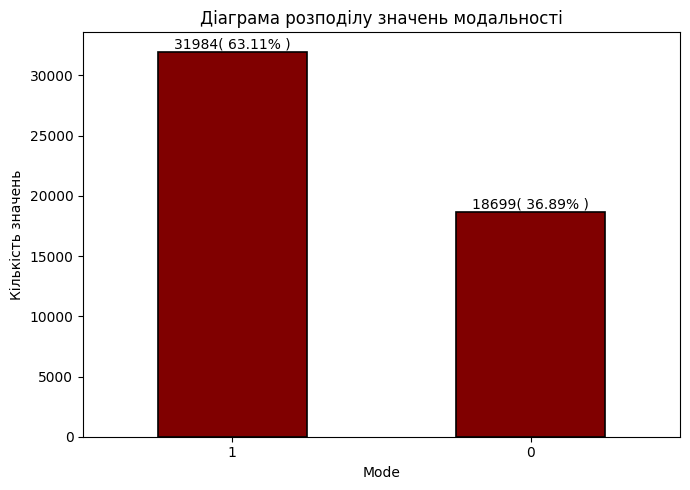

In [ ]:
plot_feature()

У цьому датасеті дані цієї колонки не рівномірно розподілені між "класами". Класу "мажор" відповідає 63%, а "мінор" - 37%, тобто веселі треки переважають.

У колонці 'time_signature' зберігається значення часового підпису треку (кількість долей в кожному такті). Взагалі в API Spotify значення цієї змінної належать проміжку [3; 7], проте в даному датасеті значення варіюються від 0 до 5 (2 пропущене).

In [ ]:
df['time_signature'].value_counts(normalize=True)

,proportion
time_signature,
4,0.887655
3,0.088807
5,0.014443
1,0.008898
0,0.000197


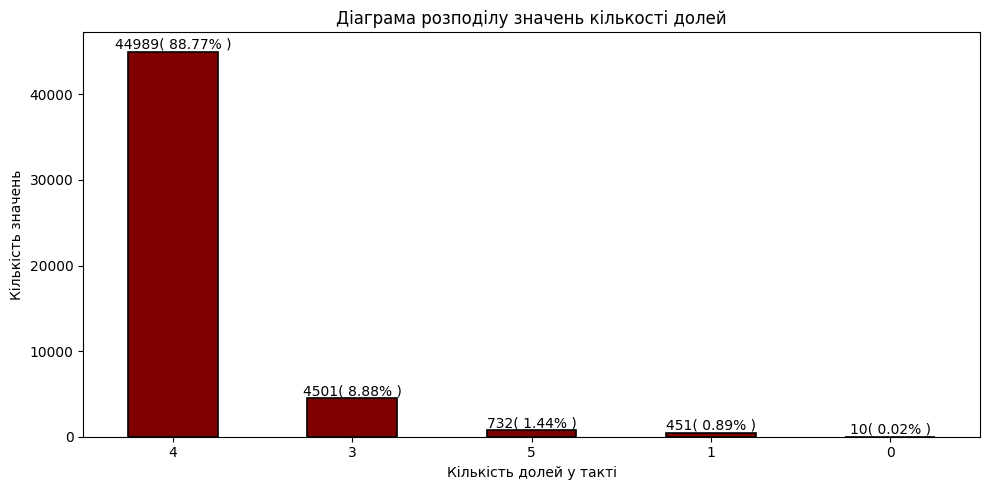

In [ ]:
plot_feature(data=df['time_signature'], xlabel='Кількість долей у такті', title='Діаграма розподілу значень кількості долей', figsize=(10,5))

З діаграми можна зробити висновок, що переважають (90%) дані, що мають значення 'time_signature' 4. Тобто дані не однорідні.

Маштабуємо дані, щоб вони знаходилися в проміжку від 0 до 1. ДЛя цього слід застосувати мінімум-максимум нормалізацію

In [ ]:
df['time_signature'] = minMaxNormalization(df['time_signature'])
df['time_signature'].min(), df['time_signature'].max()

(0.0, 1.0)

Тональність треку зберігається в колонці 'key'. Тональність - це основна нота треку. У Spotify дані варіюються від 0 до 11, якщо дані відсутні, то значення key=-1 (у даному датасеті такі значення відсутні). Співвідношення між літерами і нотами таке:
* 0 C
* 1	C♯/D♭
* 2	D
* 3	D♯/E♭
* 4	E
* 5	F
* 6	F♯/G♭
* 7	G
* 8	G♯/A♭
* 9	A
* 10	A♯/B♭
* 11	B

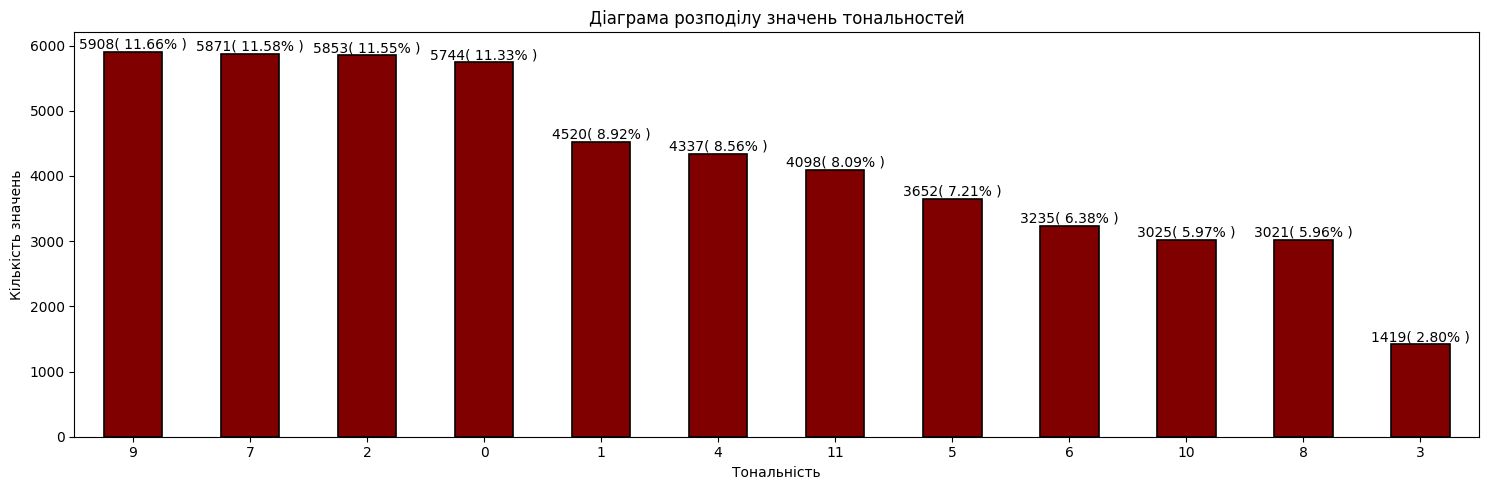

In [ ]:
plot_feature(data=df['key'], figsize=(15, 5), title='Діаграма розподілу значень тональностей', xlabel='Тональність')

З діаграми видно, що наймеше в датасеті треків зі значенням тональності - 3, а найбільше - 9. Далі маштабуємо дані на проміжку від 0 до 1

In [ ]:
df['key'] = minMaxNormalization(df['key'])
df['key'].min(), df['key'].max()

(0.0, 1.0)

Характеристика "danceability" показує наскільки трек підходить для танцювання. Значення належать проміжку від 0 до 1, де 0 - трек зовсім не підходить для танцювання і 1 - найбільш підходить.
Значення даної характеристики вираховується математично на основі значень темпу, ритмічної стабільності, сили ударів та загального стилю і ритму.

Джерело: https://rpubs.com/PeterDola/SpotifyTracks

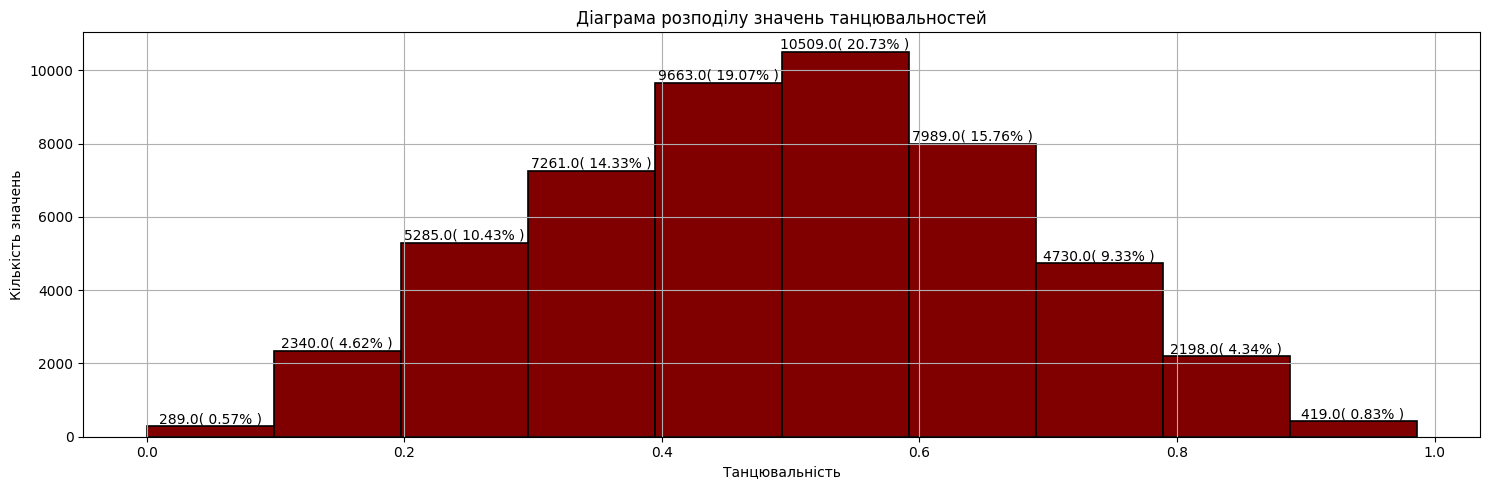

In [ ]:
plot_feature(data=df['danceability'], figsize=(15, 5), title='Діаграма розподілу значень танцювальностей', xlabel='Танцювальність', type_of_graph='hist')

Характеристика "energy" описує інтенсивність та активність треку. Чим вище значення - тим більш енергійний цей трек.

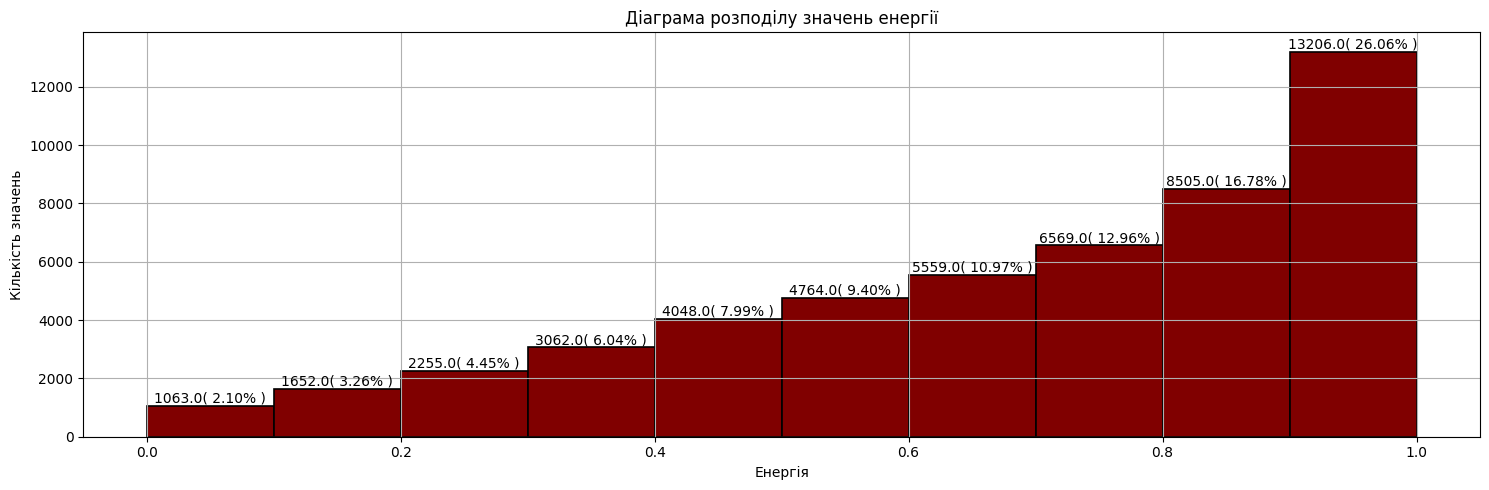

In [ ]:
plot_feature(data=df['energy'], figsize=(15, 5), title='Діаграма розподілу значень енергії', xlabel='Енергія', type_of_graph='hist')

Характеристика "loudness" описує гучність треку, чим вище значення, тим голосніший трек. Значення гучності лежить в межах від -60 до 3,642. Нормалізуємо до [0; 1]

In [ ]:
df['loudness'].min(), df['loudness'].max()

(-60.0, 3.642)

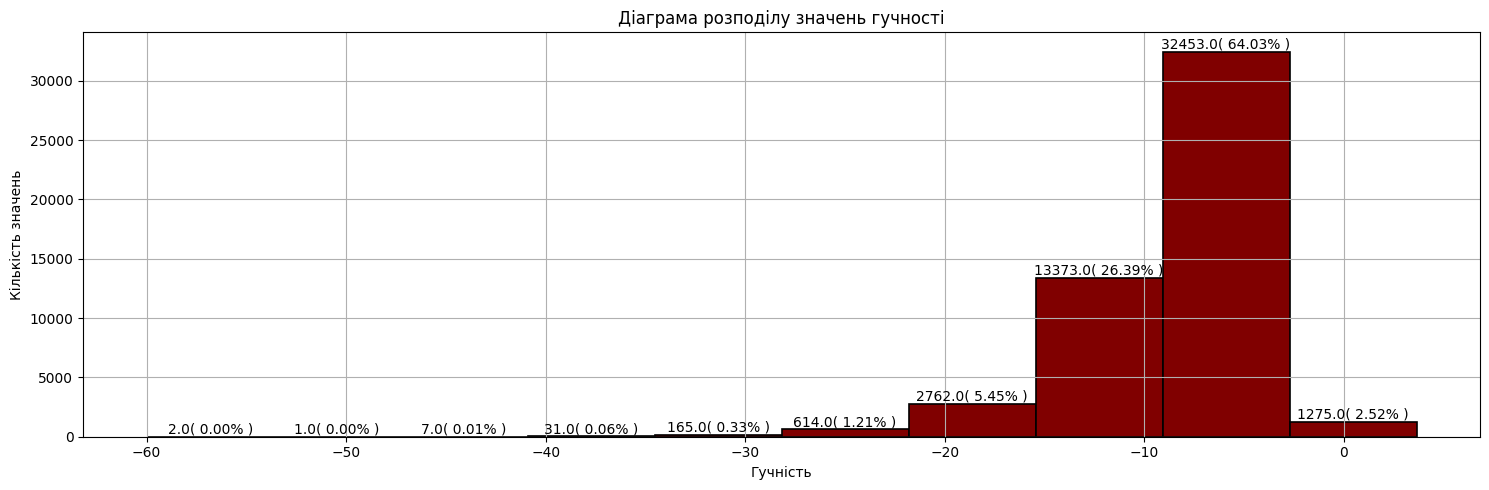

In [ ]:
plot_feature(data=df['loudness'], figsize=(15, 5), title='Діаграма розподілу значень гучності', xlabel='Гучність', type_of_graph='hist')

In [ ]:
df['loudness'] = minMaxNormalization(df['loudness'])
df['loudness'].min(), df['loudness'].max()

(0.0, 1.0)

Характеристика "speechiness" описує кількість мовлення в треці. Наприклад, якщо значення менше за 0.33, то трек ймовірно - пісня, а якщо більше 0.66 - то аудіокнига, токшоу, підкаст тощо.

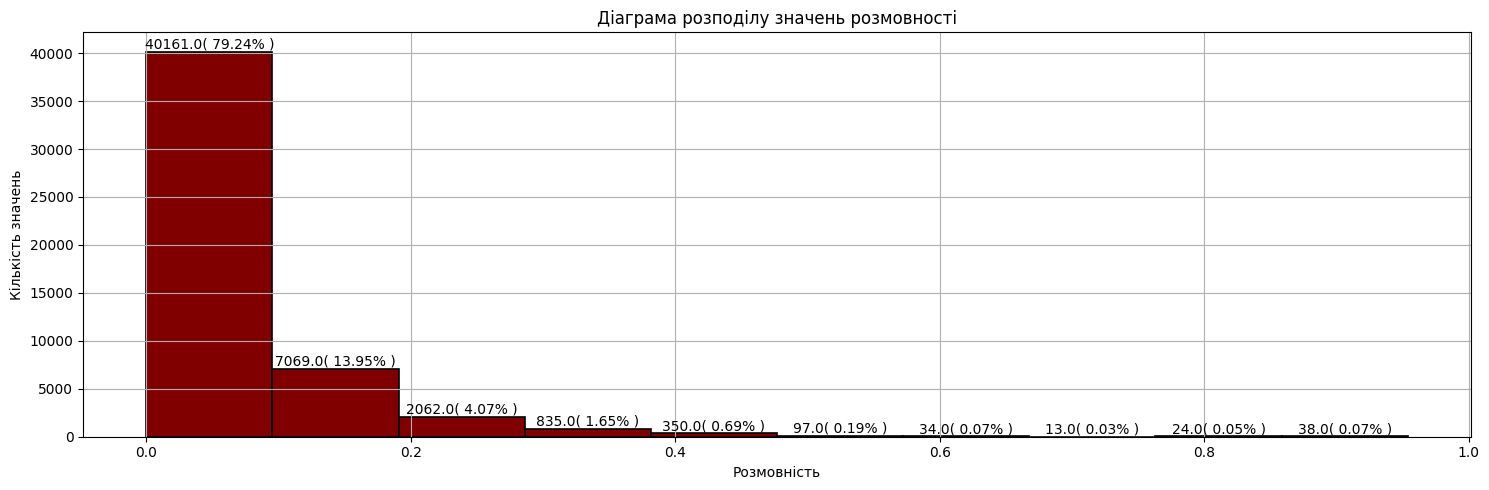

In [ ]:
plot_feature(data=df['speechiness'], figsize=(15, 5), title='Діаграма розподілу значень розмовності', xlabel='Розмовність', type_of_graph='hist')

Характеристика "acousticness" описує акустичність треку. Набуває значень від 0 до 1, де 1 - трек акустичний. Акустичність означає створення треку за допомогою інструментів, а не використання синтетичної або електронної обробки.

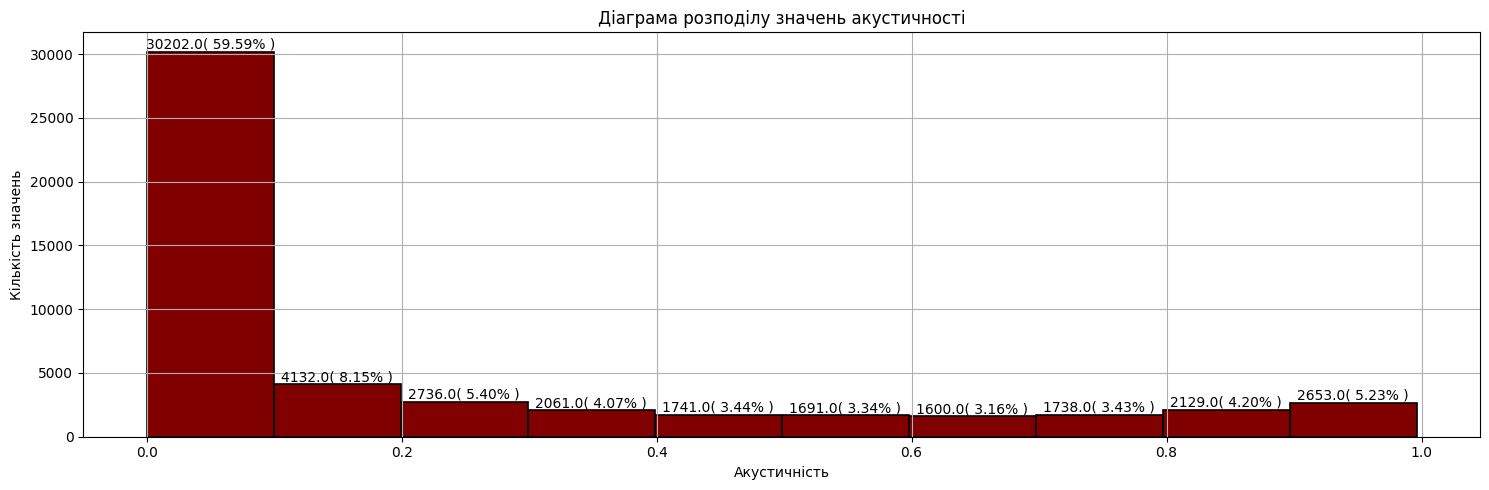

In [ ]:
plot_feature(data=df['acousticness'], figsize=(15, 5), title='Діаграма розподілу значень акустичності', xlabel='Акустичність', type_of_graph='hist')

Характеристика "instrumentalness" є протилежною до speachiness, тобто чим більше значення, тим більша ймовірність, що трек не має вокалу, а має лише інструментал.

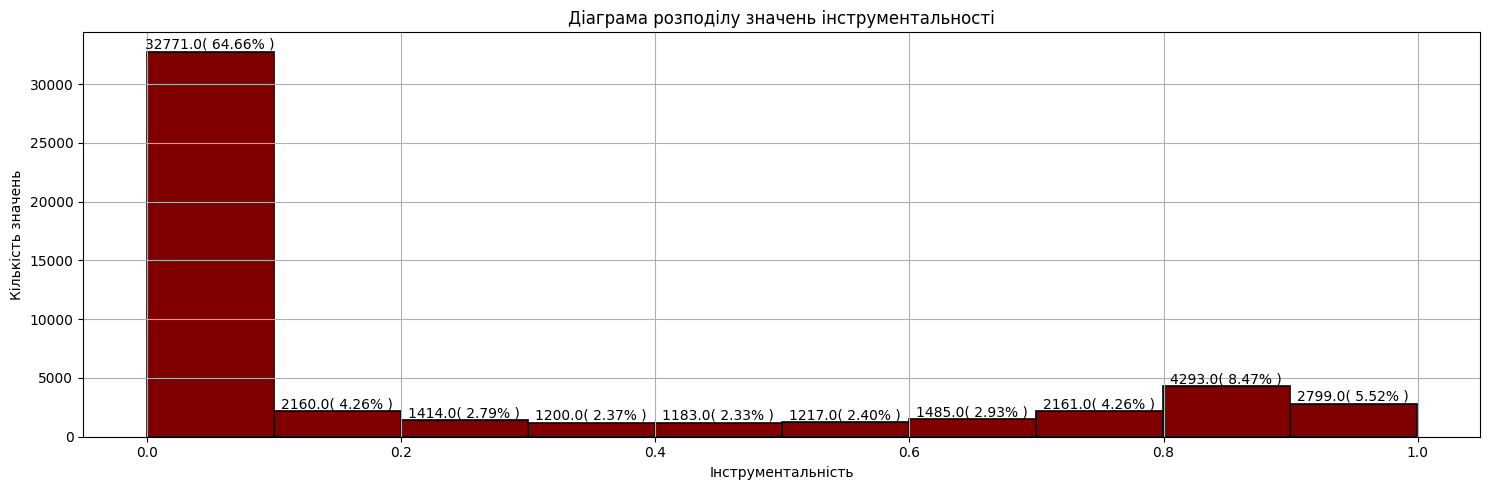

In [ ]:
plot_feature(data=df['instrumentalness'], figsize=(15, 5), title='Діаграма розподілу значень інструментальності', xlabel='Інструментальність', type_of_graph='hist')

Характеристика "liveness" позначає наявність звучання авдиторії на записі. Чим більше значення - тим більша ймовірність, що трек був записаний під час виконання наживо.

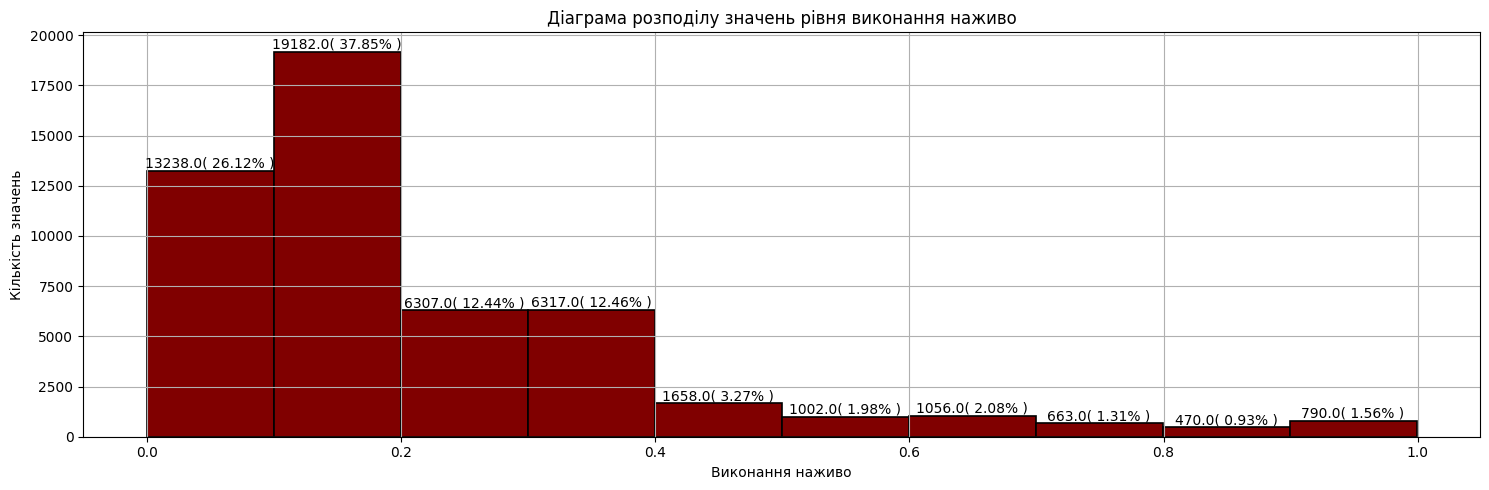

In [ ]:
plot_feature(data=df['liveness'], figsize=(15, 5), title='Діаграма розподілу значень рівня виконання наживо', xlabel='Виконання наживо', type_of_graph='hist')

Характеристика "valence" описує "веселість" треку. Спочатку це значення класифікували вручну та на основі цих класифікацій будували машинну модель, покращена версія якої використовується й сьогодні

Джерело: https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013

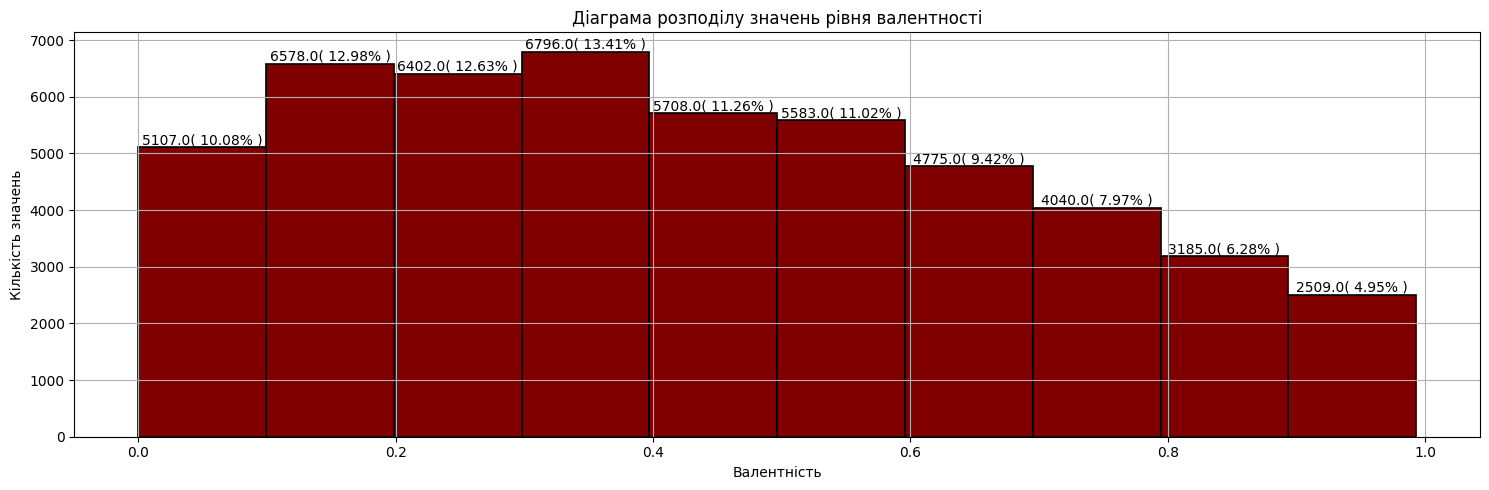

In [ ]:
plot_feature(data=df['valence'], figsize=(15, 5), title='Діаграма розподілу значень рівня валентності', xlabel='Валентність', type_of_graph='hist')

Характеристика "tempo" означає темп треку, на основі його BPM (кількості ударів на хвилину).

In [ ]:
df['tempo'].min(), df['tempo'].max()

(0.0, 238.895)

Нормалізуємо значення, щоб вони належали проміжку [0;1]

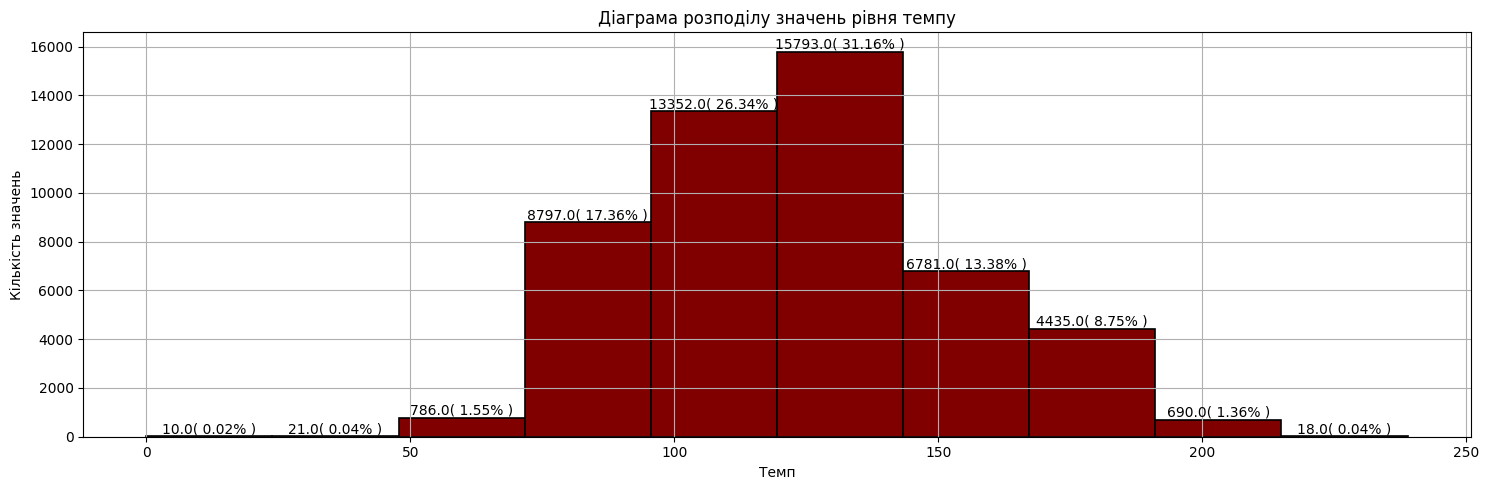

In [ ]:
plot_feature(data=df['tempo'], figsize=(15, 5), title='Діаграма розподілу значень рівня темпу', xlabel='Темп', type_of_graph='hist')

In [ ]:
df['tempo'] = minMaxNormalization(df['tempo'])
df['tempo'].min(), df['tempo'].max()

(0.0, 1.0)

In [ ]:
df[df_features].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000,50683.000000
mean,0.493537,0.686486,0.482977,0.812495,0.631060,0.076023,0.213808,0.225283,0.215425,0.433134,0.516996,0.779630
std,0.178838,0.251808,0.324371,0.071468,0.482522,0.076007,0.302848,0.337049,0.184697,0.258779,0.123992,0.083934
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.364000,0.514000,0.181818,0.779752,0.000000,0.035200,0.001400,0.000018,0.098400,0.214000,0.421453,0.800000
50%,0.497000,0.744000,0.454545,0.829641,1.000000,0.048200,0.039900,0.005630,0.138000,0.405000,0.510639,0.800000
75%,0.621000,0.905000,0.818182,0.862811,1.000000,0.083500,0.340000,0.441000,0.289000,0.634000,0.592892,0.800000
max,0.986000,1.000000,1.000000,1.000000,1.000000,0.954000,0.996000,0.999000,0.999000,0.993000,1.000000,1.000000


# **Кореляція даних**

Кореляція (corr) - статична змінна, що позначає ступінь та напрямок зв'язку між змінними.
* corr = 0 - кореляція відсутня.
* corr < 0 - кореляція від'ємна, тобто при збільшенні значення однієї змінної, значення іншої зменшується.
* corr > 0 - кореляція додатня, тобто при збільшенні значення однієї змінної, значення іншої також збільшується.

Візуалізуймо значення кореляції

In [ ]:
correlation = df[df_features].corr()

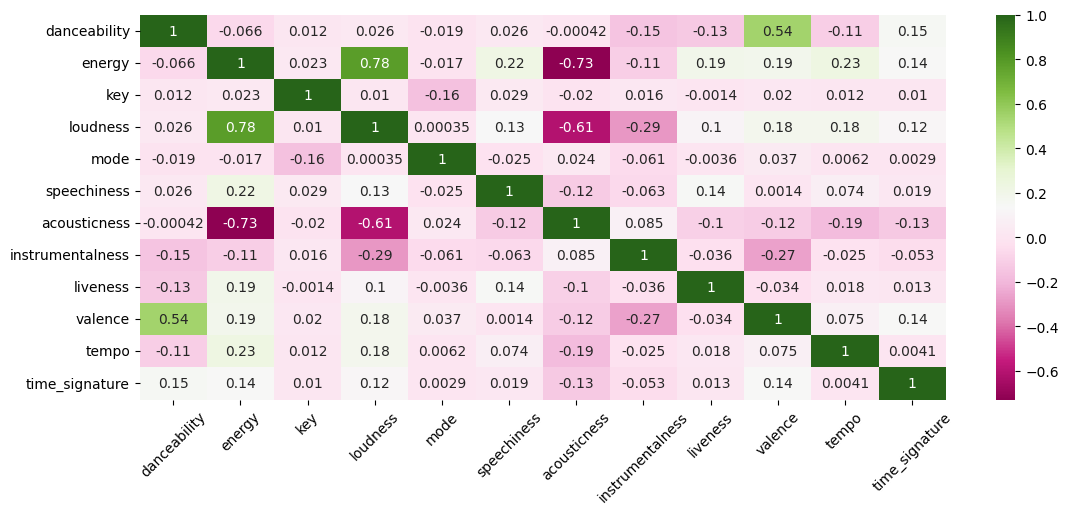

In [ ]:
plt.figure(figsize=(13,5))
sns.heatmap(data=correlation, annot=True, cmap="PiYG")
plt.xticks(rotation=45)
plt.show()

Із зображення можна зробити певні висновки. Наприклад, досить високі значення кореляції можна спостерігати між такими даними:
* енергія та гучність. Це інтуїтивно зрозуміло, оскільки чим гучніший трек, тим він енергійніший.
* валентність та танцювальність. Також очевидно, що "веселість" та танцювальність треків можуть бути пов'язані.

Також слід виділити суттєво негативну кореляцію. Наприклад,
* акустичність та енергія. При створенні енергічних треків часто використовують синтетичну обробку та автотюн, тому такий результат не є неочікуваним.
* акустичність та гучність. Також зрозуміло, що акустичні треки не будуть сильно гучними, оскільки вони мають лише вокал та вкустичні інструменти.

Всі інші характеристики мають кореляцію близьку до 0, що означає, що вони незалежні.

# **Побудова scatter графіків для відображення даних з негативною та позитивною кореляцією**

In [ ]:
def plot_corr(data:pd.DataFrame, x:str, y:str):
  fig, axes = plt.subplots(1, 2, figsize=(8, 4))

  sns.lineplot(ax=axes[0], data=data, x=x, y=y, color='maroon', alpha=0.4)
  sns.regplot(ax=axes[1], data=data, x=x, y=y, scatter_kws={'color':'maroon', 'alpha': 0.2}, line_kws={'color':'gold'})

  plt.tight_layout()
  plt.show()

In [ ]:
def count_regression_coeff(data:list):
  print(f'X = {data[0]}; y = {data[-1]}')
  model = LinearRegression()
  X = df[[data[0]]]
  y = df[data[-1]]
  model.fit(X, y)
  print(f"Коефіцієнт регресії: {model.coef_[0]}")
  print(f"Вільний член: {model.intercept_}")

  print('-'*50)
  print(f'X = {data[-1]}; y = {data[0]}')
  X = df[[data[-1]]]
  y = df[data[0]]
  model.fit(X, y)
  print(f"Коефіцієнт регресії: {model.coef_[0]}")
  print(f"Вільний член: {model.intercept_}")

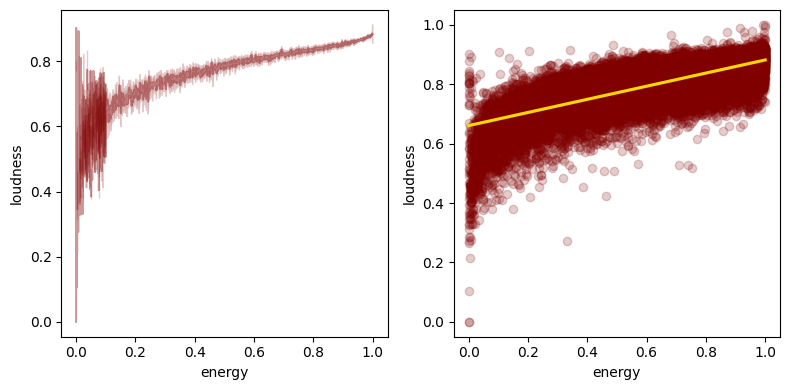

In [ ]:
plot_corr(data=df, x='energy', y='loudness')

In [ ]:
count_regression_coeff(['energy', 'loudness'])

X = energy; y = loudness
Коефіцієнт регресії: 0.2209998304814336
Вільний член: 0.6607814355782853
--------------------------------------------------
X = loudness; y = energy
Коефіцієнт регресії: 2.743523613323896
Вільний член: -1.5426122716585873


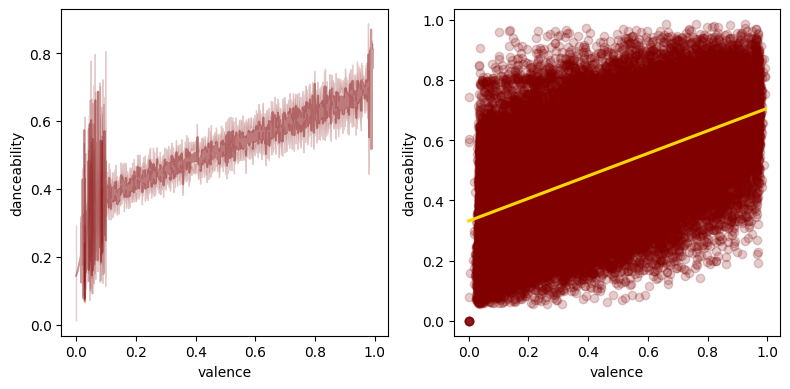

In [ ]:
plot_corr(data=df, x='valence', y='danceability')

In [ ]:
count_regression_coeff(['valence', 'danceability'])

X = valence; y = danceability
Коефіцієнт регресії: 0.37394385165583166
Вільний член: 0.33156901416953344
--------------------------------------------------
X = danceability; y = valence
Коефіцієнт регресії: 0.7829703932206725
Вільний член: 0.04670920880231999


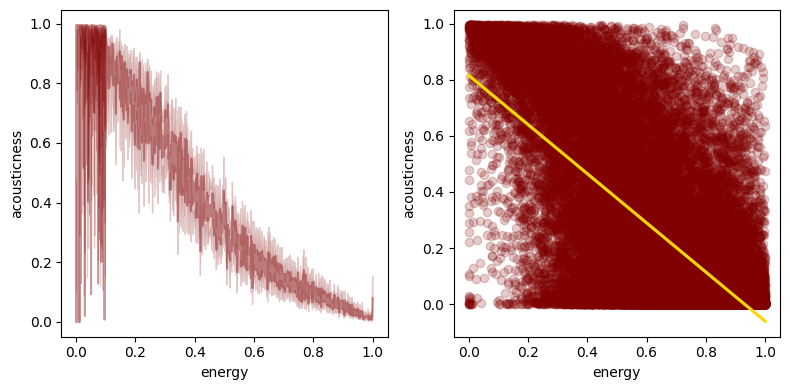

In [ ]:
plot_corr(data=df, x='energy', y='acousticness')

In [ ]:
count_regression_coeff(['energy', 'acousticness'])

X = energy; y = acousticness
Коефіцієнт регресії: -0.8776296263882014
Вільний член: 0.8162885558528807
--------------------------------------------------
X = acousticness; y = energy
Коефіцієнт регресії: -0.6067369415771169
Вільний член: 0.8162115039705338


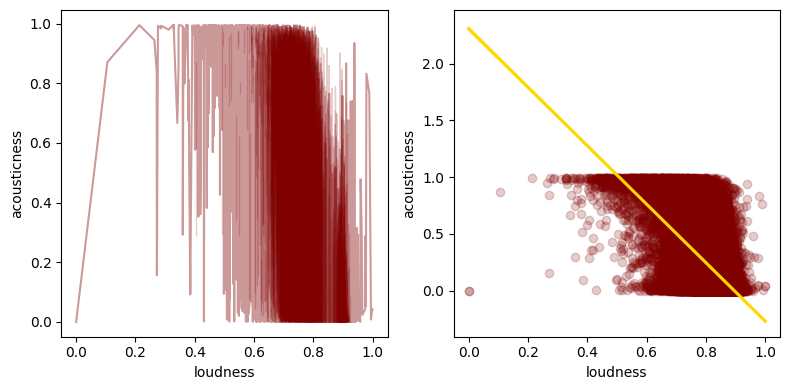

In [ ]:
plot_corr(data=df, x='loudness', y='acousticness')

In [ ]:
count_regression_coeff(['acousticness', 'loudness'])

X = acousticness; y = loudness
Коефіцієнт регресії: -0.1435881282242072
Вільний член: 0.8431950771596778
--------------------------------------------------
X = loudness; y = acousticness
Коефіцієнт регресії: -2.5783753081150387
Вільний член: 2.3087242909730206


# **Перевірка на аномалії**

In [ ]:
def detect_outliners(data:pd.DataFrame):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers = df[(data < lower_bound) | (data > upper_bound)]

  return outliers

In [ ]:
contains_outliners = []
for col in df_features:
  outliners = detect_outliners(df[col])
  if outliners.shape[0] != 0:
    contains_outliners.append(col)

In [ ]:
contains_outliners

['loudness',
 'speechiness',
 'acousticness',
 'liveness',
 'tempo',
 'time_signature']

## **Перевіряємо та візуалізуємо викиди знайдені в колонках**



In [ ]:
def visualize_boxplot(col:str):
  sns.boxplot(data=df, x=col, color='maroon')
  plt.title(f'Boxplot для {col}')
  plt.show()

In [ ]:
len(contains_outliners)

6

In [ ]:
print('Кількість викидів')
for col in contains_outliners:
  print(f'{col:<15} {detect_outliners(df[col]).shape[0]}')

Кількість викидів
loudness        1780
speechiness     5022
acousticness    3744
liveness        3211
tempo           185
time_signature  5694


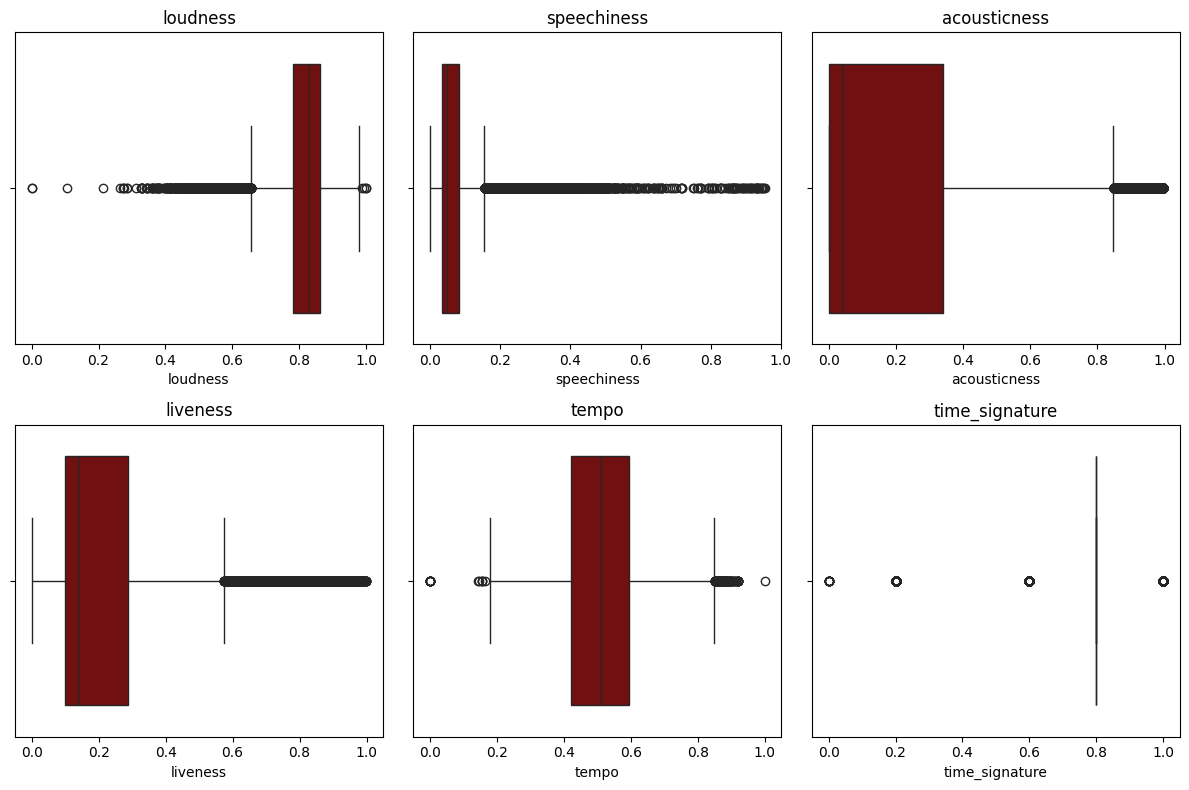

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(contains_outliners):
    sns.boxplot(data=df, x=feature, ax=axes[i], color='maroon')
    axes[i].set_title(feature)

for j in range(len(contains_outliners), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Проаналізувавши дані на кількість викидів стало зрозуміло, що їх багато і в подальшому потрібна модель, що добре з ними справляється.

In [ ]:
df.to_csv('Normalized_dataset_features.csv', index=False)